In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ericchuangg","key":"ceda6997e41469f9bf4b0b734ae977a9"}')  # TODO: Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73272 sha256=4bba593f4626cf4d8a2ba8790e8c7a8155b14b51a51e944b5d4f00564ab6541a
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


In [2]:
!kaggle datasets download -d paultimothymooney/stock-market-data

100% 1.03G/1.03G [00:34<00:00, 42.1MB/s]
100% 1.03G/1.03G [00:34<00:00, 32.4MB/s]


In [3]:
!unzip stock-market-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: stock_market_data/nasdaq/json/CLNT.json  
  inflating: stock_market_data/nasdaq/json/CLRB.json  
  inflating: stock_market_data/nasdaq/json/CLRI.json  
  inflating: stock_market_data/nasdaq/json/CLRO.json  
  inflating: stock_market_data/nasdaq/json/CLRX.json  
  inflating: stock_market_data/nasdaq/json/CLTX.json  
  inflating: stock_market_data/nasdaq/json/CLVS.json  
  inflating: stock_market_data/nasdaq/json/CLWT.json  
  inflating: stock_market_data/nasdaq/json/CLYAF.json  
  inflating: stock_market_data/nasdaq/json/CMCO.json  
  inflating: stock_market_data/nasdaq/json/CMCSA.json  
  inflating: stock_market_data/nasdaq/json/CMCT.json  
  inflating: stock_market_data/nasdaq/json/CME.json  
  inflating: stock_market_data/nasdaq/json/CMGE.json  
  inflating: stock_market_data/nasdaq/json/CMLS.json  
  inflating: stock_market_data/nasdaq/json/CMOXF.json  
  inflating: stock_market_data/nasdaq/json/CMPR.json  
  inflating:

torch.Size([8, 60]) torch.Size([8, 30])


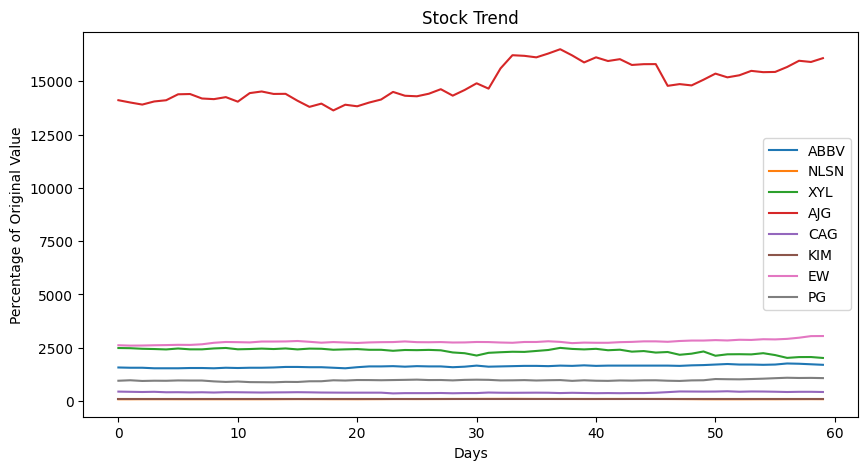

In [4]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
class CSVData(Dataset):
    def __init__(self, folder_path, training_length, predict_length):
        self.folder_path = folder_path
        self.training_length = training_length
        self.predict_length = predict_length
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.csv')][:100]
        self.data = []
        self.tickers = []

        for file in self.files:
            csv_file = pd.read_csv(os.path.join(folder_path, file))
            open_col = csv_file['Open'].values
            self.tickers.append(file.split('.')[0])
            for i in range(len(open_col) - training_length - predict_length):
                self.data.append((open_col[i:i+training_length], open_col[i+training_length:i+training_length+predict_length]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        training_data, label_data = self.data[index]
        training_data = torch.Tensor(training_data)
        label_data = torch.Tensor(label_data)
        return training_data, label_data

    def plot_trend(self, batch_data):
        plt.figure(figsize=(10, 5))
        for i in range(batch_data.size(0)):
            x = torch.arange(batch_data.shape[1])
            y = batch_data[i].numpy()  * 100
            plt.plot(x, y, label=f'{self.tickers[i]}')
        plt.xlabel('Days')
        plt.ylabel('Percentage of Original Value')
        plt.title('Stock Trend')
        plt.legend()
        plt.show()

# Example usage
folder_path = "/content/stock_market_data/sp500/csv/"
training_length = 60
predict_length = 30

dataset = CSVData(folder_path, training_length, predict_length)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate through batches of data
for batch in dataloader:
    training_data, label_data = batch
    print(training_data.shape, label_data.shape)
    # dataset.plot_trend(training_data)
    break

torch.Size([8, 60]) torch.Size([8, 30])
number of nan tensor(0) tensor(0)


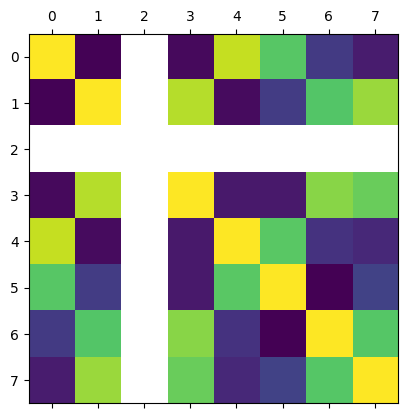

In [5]:
max_seq_len = 100
batch_size = 16

folder_path = "/content/stock_market_data/sp500/csv/"
training_length = 60
predict_length = 30

dataset = CSVData(folder_path, training_length, predict_length)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

for data in train_loader:
    
    column_data, labels = data
    print(column_data.shape, labels.shape)
    print("number of nan", torch.sum(torch.isnan(column_data)), torch.sum(torch.isnan(labels)))
    # train_loader.plot_trend(column_data, column_len)
    corr_matrix = torch.corrcoef(column_data.squeeze(-1))

    # display correlation matrix
    plt.matshow(corr_matrix, 0)
    break


In [6]:
# Define hyperparameters
batch_size = 8
learning_rate = 1e-20
hidden_size = 50
training_length = 60
predict_length = 30

train_folder_path = '/content/stock_market_data/sp500/csv/'
test_folder_path = '/content/stock_market_data/nyse/csv/'
train_dataset = CSVData(train_folder_path, training_length, predict_length)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

test_dataset = CSVData(test_folder_path, training_length, predict_length)
test_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Define the sequence length for input data to the LSTM model
sequence_length = 60
prediction_length = 30

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(seq_len, hidden_size)
        self.fc = nn.Linear(seq_len, prediction_length)
        self.fc1 = nn.Linear(seq_len, seq_len)
        self.fc2 = nn.Linear(seq_len, seq_len)

        self.fc_only_lstm = nn.Linear(hidden_size, prediction_length)
        self.gelu = nn.GELU()
        self.seq_len = seq_len

    def forward(self, x, adj_matrix):
        out, _ = self.lstm(x)
        # out2, _ = self.lstm2(out)
        # # out2 = out2.reshape(self.seq_len, -1)
        # tmp = torch.matmul(adj_matrix, out2)
        # # tmp = tmp.reshape(-1, self.seq_len)
        # tmp_out = self.fc1(tmp)
        # gelu1_out = self.gelu(tmp_out)

        # tmp = torch.matmul(adj_matrix, gelu1_out)
        # tmp_out = self.fc2(tmp)
        # gelu1_out = self.gelu(tmp_out)

        out = self.fc_only_lstm(out.reshape(batch_size, -1))
        return out


In [17]:
learning_rate = 1e-6
device = 'cuda'

model = StockLSTM(input_size=60, hidden_size=hidden_size, seq_len=training_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss().to(device)
overall_avg_loss = []
overall_test_loss = []

import numpy as np
import pandas as pd

def create_adj_matrix(data, threshold = 0.8):
    """
    Creates an adjacency matrix for a correlation graph given a pandas DataFrame of stock prices and a threshold value.

    :param data: pandas DataFrame of stock prices with each column representing a stock and each row representing a day
    :param threshold: minimum correlation coefficient value for an edge to be included in the graph
    :return: a numpy ndarray representing the adjacency matrix
    """
    # Calculate the correlation matrix
    # print(data.squeeze(-1))
    corr_matrix = torch.corrcoef(data.squeeze(-1))

    nan_indices = torch.isnan(corr_matrix)
    corr_matrix[nan_indices] = 0.0

    # adj_matrix = np.where(np.abs(corr_matrix) >= threshold, 1, 0)
    # return torch.from_numpy(adj_matrix).float()

    return corr_matrix

from tqdm import tqdm
num_epochs = 100

from sklearn.preprocessing import normalize
import numpy as np


def scale(X):
  '''
  Scales each row so that the largest value is 1.0
  '''
  eps = 1e-12
  scaled_X = (X - 0) / (torch.max(X, axis=1).values - 0 + eps).unsqueeze(1)
  return scaled_X, torch.max(X, axis=1).values.unsqueeze(1)

for epoch in range(num_epochs):
    running_loss = 0.0
    # Wrap the train_loader with tqdm for progress bar
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        column_data, labels = data
        optimizer.zero_grad()
        if torch.sum(torch.isnan(column_data)) + torch.sum(torch.isnan(labels))> 0:
          continue

        column_data, scaling_factor = scale(column_data)
        
        adj_matrix = create_adj_matrix(column_data)
        column_data = column_data.to(device)
        outputs = model(column_data, adj_matrix)

        labels = labels.to(device)
        outputs= outputs.to(device)
        loss = loss_fn(outputs, labels / (scaling_factor.to(device) + 1e-12))
        # print(loss.item())

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99 :
          print(running_loss / (i + 1))
        # Print the average loss every 100 batches
        # if i % 100 == 99:
        #     model.eval()
        #     test_loss = 0.0
        #     for test_data in test_loader:
        #         column_data_test, y_test = test_data
        #         optimizer.zero_grad()
        #         adj_matrix_test = create_adj_matrix(column_data_test)

        #         y_pred = model(column_data, adj_matrix_test)
        #         test_loss += loss_fn(y_pred, y_test)

        #     print(test_loss.item() / len(test_loader))
        #     overall_test_loss.append(test_loss.item() / len(test_loader))
        #     print(f"Epoch {epoch + 1}, Batch {i + 1}: Average Loss = {running_loss / 100}")
        #     overall_avg_loss.append(running_loss / 100)
        #     running_loss = 0.0
        #     model.train()
            
    # Print the average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average Loss = {avg_loss}")
    overall_avg_loss.append(avg_loss)

  0%|          | 143/103783 [00:00<07:31, 229.64it/s]

6.840007441355247e+19


  0%|          | 232/103783 [00:01<06:19, 272.98it/s]

1.2395874759845224e+22


  0%|          | 347/103783 [00:01<06:28, 266.52it/s]

5.224511690194547e+22


  0%|          | 431/103783 [00:01<06:23, 269.59it/s]

2.505238956609523e+23


  1%|          | 556/103783 [00:02<05:55, 290.31it/s]

2.0042922251963135e+23


  1%|          | 643/103783 [00:02<06:22, 269.78it/s]

1.6712940309955066e+23


  1%|          | 728/103783 [00:02<06:19, 271.30it/s]

1.4327569524533275e+23


  1%|          | 848/103783 [00:03<05:59, 286.50it/s]

1.2538872606979435e+23


  1%|          | 941/103783 [00:03<05:43, 299.41it/s]

1.1168618013740496e+23


  1%|          | 1033/103783 [00:03<05:49, 293.97it/s]

1.0078335702081534e+23


  1%|          | 1126/103783 [00:04<05:57, 287.05it/s]

9.196644237842288e+22


  1%|          | 1247/103783 [00:04<05:48, 294.45it/s]

8.431437804910516e+22


  1%|▏         | 1350/103783 [00:04<05:07, 333.65it/s]

9.931702918968627e+22


  1%|▏         | 1474/103783 [00:05<04:25, 385.92it/s]

9.223227059358762e+22


  2%|▏         | 1557/103783 [00:05<04:16, 399.15it/s]

8.779538034795999e+22


  2%|▏         | 1681/103783 [00:05<04:11, 406.24it/s]

8.231712203383183e+22


  2%|▏         | 1768/103783 [00:05<04:02, 419.94it/s]

7.795128452203155e+22


  2%|▏         | 1852/103783 [00:06<04:16, 396.93it/s]

7.362093668546615e+22


  2%|▏         | 1978/103783 [00:06<04:08, 409.15it/s]

6.984053433399234e+22


  2%|▏         | 2063/103783 [00:06<04:06, 413.39it/s]

6.682087952436872e+22


  2%|▏         | 2146/103783 [00:06<04:14, 398.70it/s]

6.3706593434285065e+22


  2%|▏         | 2267/103783 [00:07<04:22, 386.73it/s]

6.0997291891746736e+22


  2%|▏         | 2349/103783 [00:07<04:15, 397.71it/s]

6.994825924371763e+22


  2%|▏         | 2474/103783 [00:07<04:08, 407.20it/s]

6.748026528905858e+22


  2%|▏         | 2558/103783 [00:07<04:08, 407.53it/s]

6.479057065304522e+22


  3%|▎         | 2640/103783 [00:08<04:15, 396.58it/s]

6.237958212832451e+22


  3%|▎         | 2769/103783 [00:08<04:03, 415.24it/s]

6.00751815532127e+22


  3%|▎         | 2854/103783 [00:08<04:04, 412.06it/s]

5.910211776258616e+22


  3%|▎         | 2985/103783 [00:09<03:58, 423.13it/s]

5.710765642577002e+22


  3%|▎         | 3069/103783 [00:09<04:16, 393.40it/s]

5.522081277657047e+22


  3%|▎         | 3149/103783 [00:09<04:24, 380.82it/s]

5.533357321882331e+22


  3%|▎         | 3270/103783 [00:09<04:15, 392.93it/s]

5.360439905573508e+22


  3%|▎         | 3352/103783 [00:09<04:12, 398.48it/s]

7.808317802205083e+22


  3%|▎         | 3472/103783 [00:10<04:16, 390.60it/s]

7.650153231155883e+22


  3%|▎         | 3553/103783 [00:10<04:30, 370.54it/s]

7.449028733774361e+22


  4%|▎         | 3680/103783 [00:10<04:12, 396.98it/s]

7.2424465728545275e+22


  4%|▎         | 3767/103783 [00:11<04:05, 407.91it/s]

7.0856835966699016e+22


  4%|▎         | 3852/103783 [00:11<04:02, 411.55it/s]

6.955477258358539e+22


  4%|▍         | 3982/103783 [00:11<03:58, 419.28it/s]

6.9546208318669105e+22


  4%|▍         | 4066/103783 [00:11<03:58, 418.03it/s]

6.781639319629312e+22


  4%|▍         | 4151/103783 [00:11<03:57, 419.72it/s]

6.62780194313863e+22


  4%|▍         | 4276/103783 [00:12<04:04, 406.36it/s]

6.482121625228007e+22


  4%|▍         | 4358/103783 [00:12<04:10, 397.67it/s]

6.341883698205774e+22


  4%|▍         | 4481/103783 [00:12<04:07, 400.98it/s]

6.198254402329576e+22


  4%|▍         | 4569/103783 [00:12<03:56, 419.40it/s]

6.060520005953537e+22


  4%|▍         | 4653/103783 [00:13<04:04, 405.24it/s]

6.008686712432748e+22


  5%|▍         | 4776/103783 [00:13<04:04, 405.05it/s]

5.887941196938346e+22


  5%|▍         | 4861/103783 [00:13<04:02, 407.47it/s]

5.765905561919694e+22


  5%|▍         | 4947/103783 [00:13<03:57, 416.67it/s]

5.650057481189904e+22


  5%|▍         | 5073/103783 [00:14<04:00, 409.71it/s]

5.590503168645336e+22


  5%|▍         | 5158/103783 [00:14<03:59, 411.03it/s]

5.480897512038102e+22


  5%|▌         | 5244/103783 [00:14<03:54, 420.26it/s]

5.376130466223704e+22


  5%|▌         | 5371/103783 [00:14<04:10, 393.05it/s]

5.777865322951486e+22


  5%|▌         | 5449/103783 [00:15<04:37, 354.41it/s]

5.671304816921946e+22


  5%|▌         | 5555/103783 [00:15<04:50, 338.00it/s]

5.5705504185372935e+22


  5%|▌         | 5657/103783 [00:15<04:59, 327.19it/s]

5.571306025185106e+22


  6%|▌         | 5759/103783 [00:16<04:55, 332.10it/s]

5.587841924401808e+22


  6%|▌         | 5860/103783 [00:16<04:58, 328.15it/s]

5.491510759293535e+22


  6%|▌         | 5962/103783 [00:16<04:53, 332.87it/s]

5.398442820091702e+22


  6%|▌         | 5997/103783 [00:16<04:35, 355.23it/s]


KeyboardInterrupt: ignored

In [23]:
model.eval()
with torch.no_grad():
  for test_data in test_loader:
      
      column_data_test, y_test = test_data
      column_data_test = column_data_test.to(device)
      y_test= y_test.to(device)
      column_data_test, scaling_factor = scale(column_data_test)

      optimizer.zero_grad()
      adj_matrix_test = create_adj_matrix(column_data_test)
      
      y_pred = model(column_data_test, adj_matrix_test) 
      y_pred *= scaling_factor.to(device)
      break
    # test_loss += loss_fn(y_pred, y_test)

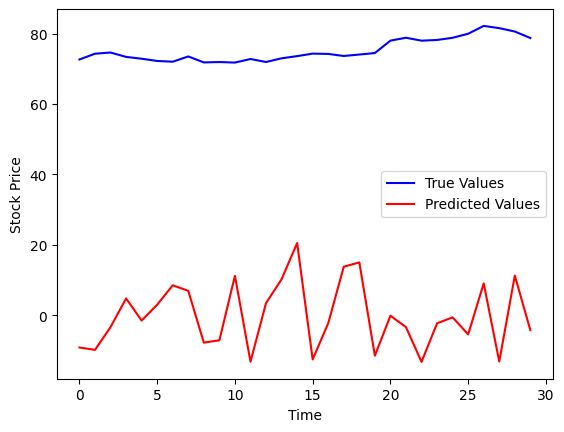

In [27]:
import matplotlib.pyplot as plt

# Plot the true values in blue
plt.plot(y_test.cpu().numpy()[2], color='blue', label='True Values')

# Plot the predicted values in red
plt.plot(y_pred.cpu().numpy()[2], color='red', label='Predicted Values')

# Add axis labels and a legend
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()